<a href="https://colab.research.google.com/github/hukim1112/LLM_application/blob/main/5_LangGraph_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-dotenv
!pip install langchain
!pip install langchain-core
!pip install langchain-community
!pip install langchain-openai
!pip install langgraph

In [ ]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

### Travily API 사용하기

Travily는 LLM과 web 검색을 연동하기 위한 API입니다. 역시 API를 사용하기 위해 Key값을 받아와야 합니다.

[Travily.com](https://app.tavily.com/)에 접속해 가입하고, API key를 생성합시다.

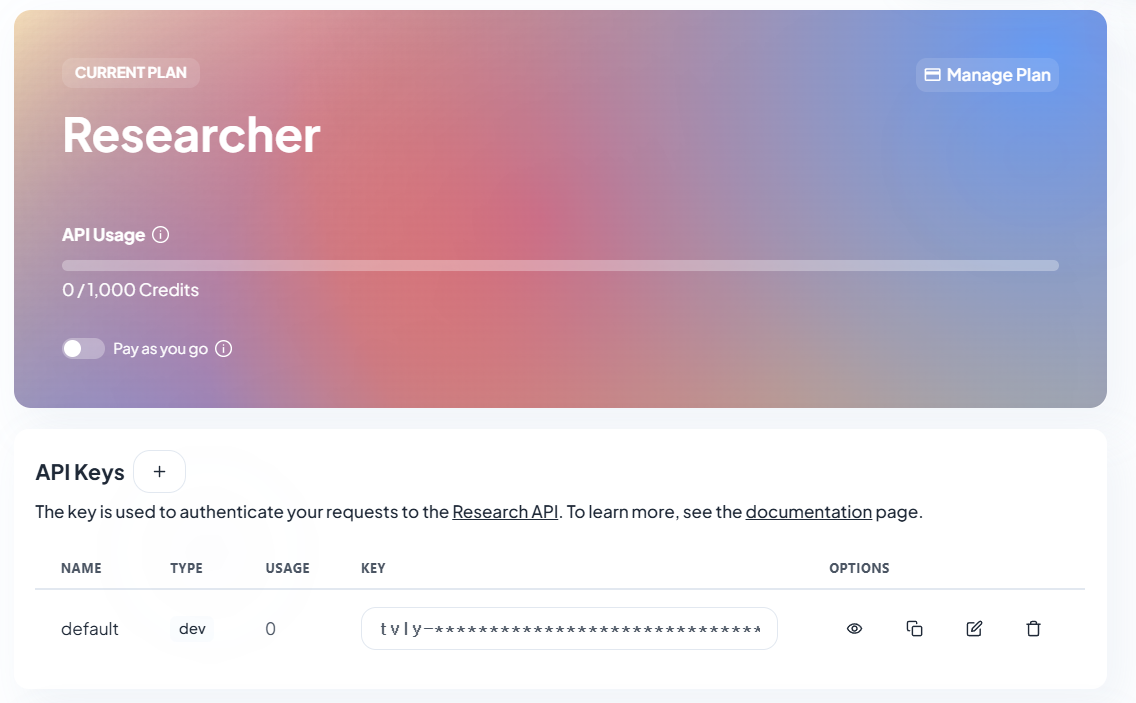

API KEY를 복사했다면, 아래에 입력하여 환경변수로 등록해줍니다.

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [ ]:
_set_env("TAVILY_API_KEY")

### ChatModel

기본적으로 품질, 가격, 속도의 균형이 좋은 gpt-4o를 사용하겠습니다.

In [ ]:
from langchain_openai import ChatOpenAI

# OpenAI의 ChatOpenAI 모델(GPT-4o)을 사용하여 LLM 초기화
llm = ChatOpenAI(model="gpt-4o")  # 언어 모델을 gpt-4o로 설정

### Tool

LangChain의 Tool은 **언어 모델(LLM)**이 직접 실행할 수 있는 외부 함수나 API를 말합니다. LLM은 자연어 처리 능력만으로 제한적일 수 있으므로, 특정 작업(예: 데이터 검색, 계산, 파일 읽기 등)을 수행하기 위해 외부의 도구를 호출합니다.

Tool 예시


1. 검색 및 정보 검색:
질문과 관련된 문서를 검색.
예: retrieve 함수로 벡터 검색을 수행.
2. 계산:
LLM이 수행할 수 없는 복잡한 수학 계산.
예: calculator Tool로 수식 계산.
3. API 호출:
외부 서비스와 통합.
예: 날씨 API 호출, 번역 API 호출.
4. 파일 처리:
로컬 파일을 읽거나 쓰는 작업.
예: CSV 데이터를 분석하고 요약.

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_search = TavilySearchResults(max_results=3)
search_docs = tavily_search.invoke("한국 계엄령")

In [ ]:
search_docs

간단한 Tool을 다음과 같이 직접 정의할 수도 있습니다.

In [ ]:
'''
from langchain_core.tools import tool

@tool(response_format="text")
def add_numbers(a: int, b: int) -> str:
    """두 숫자를 더합니다."""
    return str(a + b)
'''

# LangGraph 소개

LangGraph는 프로세스 흐름을 노드(작업 단위), 엣지(연결), 상태(데이터), 조건부 엣지(분기 로직)로 표현하여 복잡한 작업을 직관적으로 설계하고 실행할 수 있는 프레임워크입니다.

### 노드(Node), 엣지(Edge), 상태(State), 조건부 엣지(Conditional edge) 개념 이해

- 노드 : LangGraph에서 작업 단위(예: 함수 호출, 질문 응답, 상태 업데이트 등)를 나타내는 구성 요소입니다. 어떤 작업을 할 지 정의하는 함수입니다.
- 엣지 : 노드 간의 연결을 나타내며, 실행 순서를 지정하는 구성 요소입니다. 다음으로 실행할 동작을 정의합니다.
- 상태 : 그래프가 공유하는 현재의 상태값을 저장하고 전달합니다.
- 조건부 엣지 : 특정 조건에 따라 실행 경로를 선택하는 엣지입니다. 상태나 입력 값에 따라 다른 노드로의 연결을 결정

예제: 고객 지원 챗봇 워크플로우
LangGraph를 사용하여 고객 지원 챗봇을 설계한다고 가정해봅니다.

1. 노드 구성:
- 노드 A: 사용자의 질문을 분석 (예: "이 질문은 어떤 유형인가?")
- 노드 B: FAQ 데이터베이스에서 답변 검색
- 노드 C: 상담사 연결 요청 처리
- 노드 D: 사용자에게 답변 제공

2. 엣지 연결:
- 노드 A → 노드 B: 질문이 데이터베이스에서 해결 가능할 경우
- 노드 A → 노드 C: 질문이 데이터베이스에서 해결 불가능한 경우

3. 상태 관리:
- 상태 Q: 사용자가 입력한 질문
- 상태 Answer: 검색된 답변
- 상태 Is_resolve: 질문이 자동으로 처리 가능한지 여부 (Boolean 값)

4. 조건부 엣지:
- 노드 A → 노드 B (조건: Is_resolve == YES)
- 노드 A → 노드 C (조건: Is_resolve == NO)


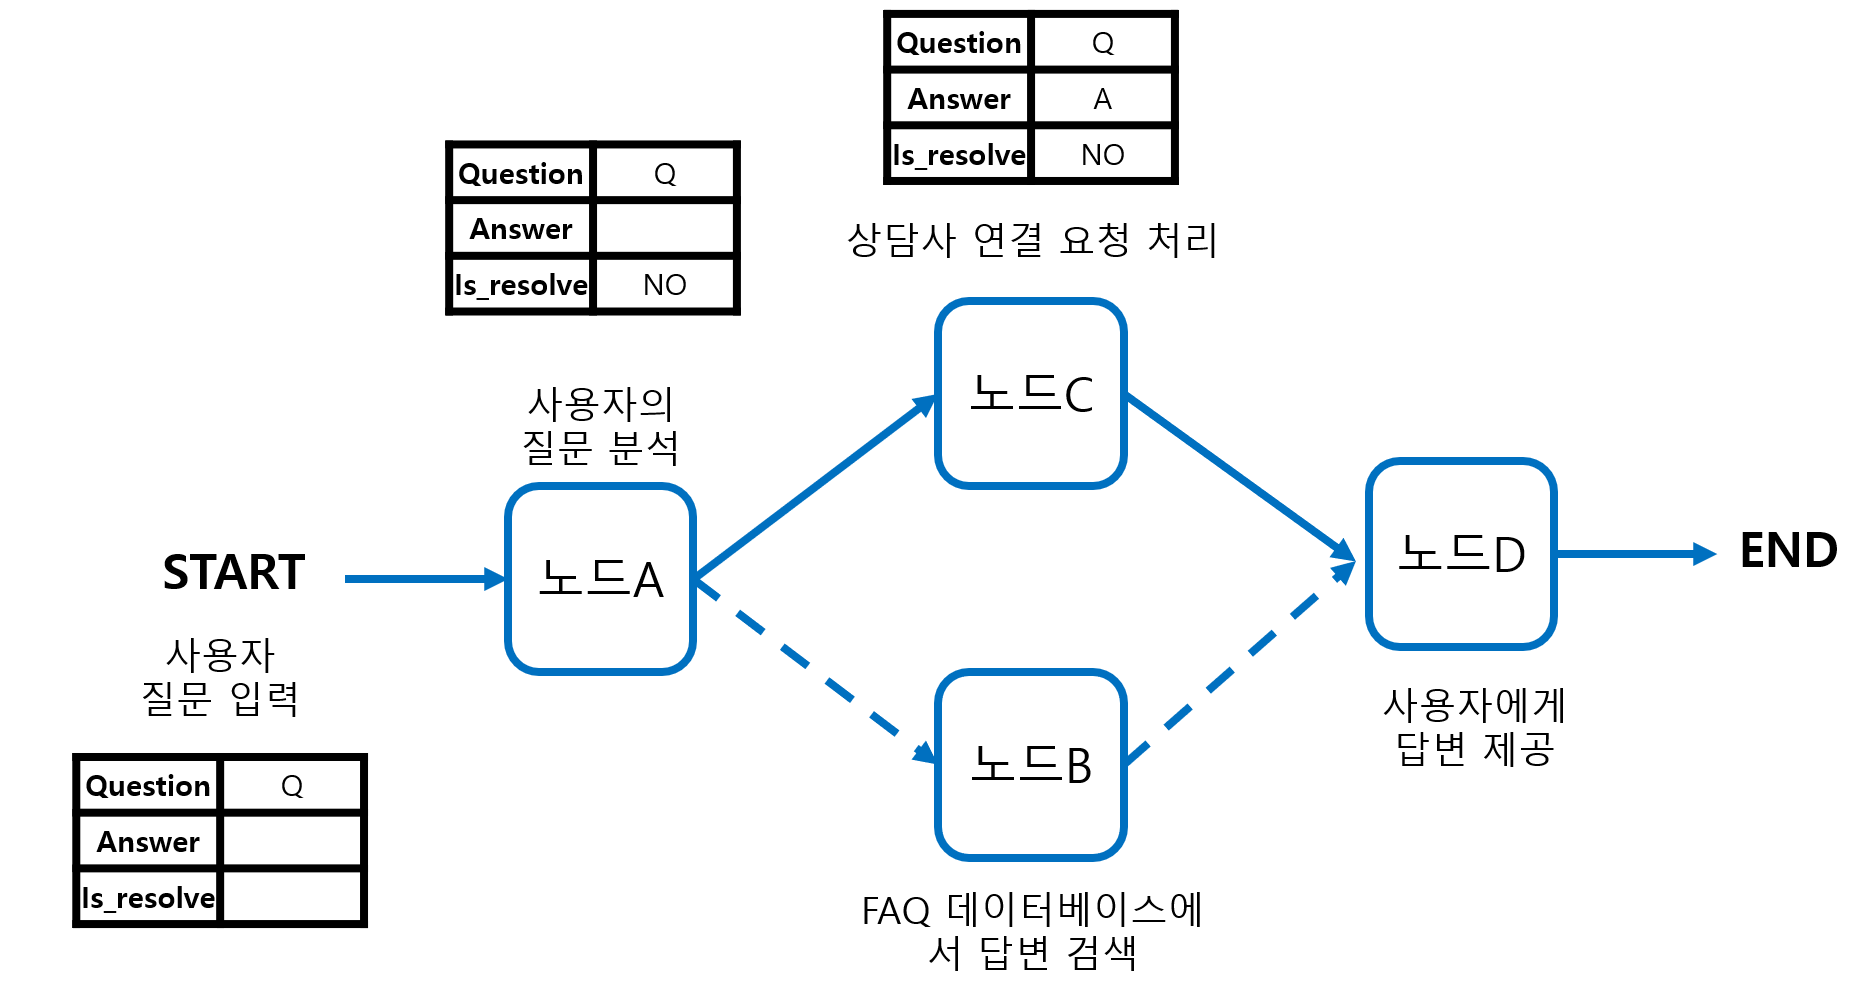

먼저 그래프의 **상태(State)**를 정의합니다.

상태 스키마는 그래프 내 모든 노드와 엣지의 입력 스키마로 사용됩니다.

Python의 typing 모듈에서 제공하는 TypedDict 클래스를 스키마로 사용하겠습니다. 이 클래스는 키에 대한 타입 정보를 줍니다.

In [ ]:
from typing_extensions import TypedDict

# 실종의 Dictionary 형태의 정보. 각 노드는 상태를 업데이트.
class State(TypedDict):
    graph_state: str

**노드(Nodes)**는 단순히 Python 함수입니다.

첫 번째 위치 인자는 위에서 정의한 **상태(State)**입니다.

상태는 위에서 정의된 스키마를 가진 TypedDict이므로, 각 노드는 state['graph_state']를 통해 graph_state 키에 접근할 수 있습니다.

각 노드는 graph_state 키의 새로운 값을 반환합니다.

기본적으로, 각 노드에서 반환된 새로운 값은 이전 상태 값을 덮어씁니다

In [ ]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" 나는"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" 행복해!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" 슬퍼!"}

**엣지(Edges)**는 노드들을 연결합니다.

- 일반 엣지(Normal Edges): 언제나 node A에서 node B로 이동하고 싶을 때 사용됩니다.
- 조건부 엣지(Conditional Edges): 조건에 따라 노드 간 경로를 설정(A->B or A->C)할 때 사용됩니다.

조건부 엣지는 특정 로직에 따라 다음에 방문할 노드를 반환하는 함수로 구현됩니다.

In [ ]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:

    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state']

    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"

    # 50% of the time, we return Node 3
    return "node_3"

### Graph 연결

이제, 위에서 정의한 구성 요소를 사용하여 그래프를 만듭니다.

StateGraph 클래스는 우리가 사용할 그래프 클래스입니다. State 클래스를 사용하여 StateGraph를 초기화합니다.

그런 다음, 노드와 엣지를 그래프에 추가합니다.

START 노드는 사용자 입력을 그래프로 전달하는 특별한 노드로, 그래프의 시작점을 나타냅니다.

END 노드는 그래프의 종료점을 나타내는 특별한 터미널 노드입니다.

마지막으로, 그래프 구조에 대한 기본적인 검사를 수행하기 위해 그래프를 컴파일합니다.

그래프는 Mermaid 다이어그램으로 시각화할 수 있습니다.

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
for i in range(5):
    print(graph.invoke({"graph_state" : "안녕, 나는 티니핑이야!"}))

# LangGraph Agent

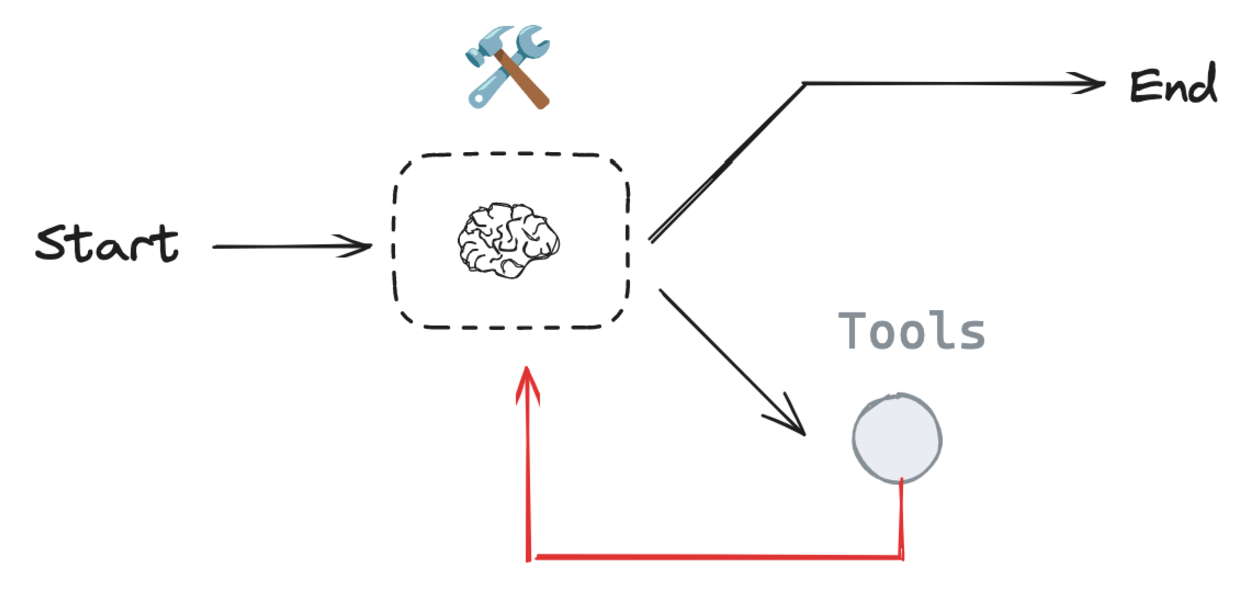

**Agent**는 LangGraph에서 주어진 작업을 수행하고, 필요한 경우 외부 도구를 호출하여 로직을 실행하는 주체입니다.

주로 LLM(언어 모델)을 기반으로 하며, 그래프 내에서 **도구(Functions)**와 상호작용하여 복잡한 작업을 처리합니다.

Agent는 LangGraph 내의 상태를 관리하고, 입력 데이터를 분석하며, 필요한 작업을 수행하거나 다음 단계로 데이터를 전달합니다.

In [ ]:
from langchain_openai import ChatOpenAI  # LangChain의 OpenAI LLM API를 불러옴

# 두 수를 곱하는 함수 정의
def multiply(a: int, b: int) -> int:
    """a와 b를 곱합니다.

    Args:
        a: 첫 번째 정수
        b: 두 번째 정수
    """
    return a * b

# 두 수를 더하는 함수 정의 (도구로 사용될 예정)
def add(a: int, b: int) -> int:
    """a와 b를 더합니다.

    Args:
        a: 첫 번째 정수
        b: 두 번째 정수
    """
    return a + b

# 두 수를 나누는 함수 정의
def divide(a: int, b: int) -> float:
    """a를 b로 나눕니다.

    Args:
        a: 첫 번째 정수
        b: 두 번째 정수
    """
    return a / b


# 사용 가능한 도구 목록 정의
tools = [add, multiply, divide]  # 정의된 함수들을 도구로 등록

In [ ]:
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)
# LLM과 도구를 연결하여 바인딩
# - tools: LLM이 호출할 수 있는 함수 목록
# - parallel_tool_calls=False: 도구 호출을 순차적으로 수행

이제 우리의 llm은 Message에 따라 response 내 function call을 합니다.

In [ ]:
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage

tool_call = llm_with_tools.invoke([HumanMessage(content=f"2와 3을 곱하면?")])
tool_call

In [ ]:
tool_call.tool_calls

In [ ]:
# 도구 호출 정보 추출
tool_info = tool_call.tool_calls[0]  # 첫 번째 도구 호출 정보
tool_name = tool_info['name']  # 호출된 도구 이름
tool_args = tool_info['args']  # 도구 호출 시 전달된 인수


print(tool_info)
print(tool_name)
print(tool_args)

In [ ]:
# llm이 사용할 tool과 argument를 올바르게 예측했다면, 아래처럼 실행도 가능하겠죠?

# 곱셈 도구를 실행해봅시다.
if tool_name == "multiply":
    result = multiply(**tool_args)  # {'a': 2, 'b': 3}를 전달해 곱셈 수행
    print("곱셈 결과:", result)

### Graph 구조 속에서 수행해봅시다!

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# 시스템 메시지 정의  LLM이 수행할 역할과 컨텍스트를 설명
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# 어시스턴트 노드 정의
# - state: MessagesState 객체로, 현재 대화 상태를 포함
def assistant(state: MessagesState):
    # LLM 호출
    # - 시스템 메시지(sys_msg)와 상태 메시지(state["messages"])를 결합하여 처리
    return {
        "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]
    }

In [ ]:
from langgraph.graph import START, StateGraph  # 그래프 시작점과 StateGraph 클래스
from langgraph.prebuilt import tools_condition  # 도구 호출 조건을 확인하는 조건부 로직
from langgraph.prebuilt import ToolNode  # 도구 노드를 정의하는 미리 빌드된 클래스
from IPython.display import Image, display  # 이미지를 표시하는 유틸리티

# 그래프 초기화
# - MessagesState를 기반으로 StateGraph를 생성
builder = StateGraph(MessagesState)

# 노드 정의
# - assistant: LLM과 도구를 활용하여 메시지를 처리
builder.add_node("assistant", assistant)
# - tools: 정의된 도구(add, multiply, divide)를 처리하는 노드
builder.add_node("tools", ToolNode(tools))

# 엣지 정의
# - START -> assistant: 그래프 시작점에서 assistant 노드로 이동
builder.add_edge(START, "assistant")

# 조건부 엣지 정의
# - assistant -> tools 또는 END: tools_condition에 따라 다음 노드를 결정
#   - 결과 메시지가 도구 호출이면 tools 노드로 이동
#   - 도구 호출이 아니면 END로 이동
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)

# 추가 엣지 정의
# - tools -> assistant: tools 노드에서 assistant 노드로 다시 연결
builder.add_edge("tools", "assistant")

# 그래프 컴파일
# - 정의된 노드와 엣지를 기반으로 그래프를 빌드
react_graph = builder.compile()

# 그래프 시각화
# - Mermaid 다이어그램으로 생성된 그래프를 PNG 이미지로 표시
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))


In [ ]:
messages = [HumanMessage(content="3과 4를 더하세요. 결과에 2를 곱하세요. 결과에 5를 나누세요.")]
messages = react_graph.invoke({"messages": messages})

In [ ]:
for m in messages['messages']:
    m.pretty_print()

### Agent에게 Memory를 사용하게 해보겠습니다.

In [ ]:
# 첫 번째 메시지를 정의
messages = [HumanMessage(content="3과 4를 더하라.")]
# react_graph를 실행하여 메시지를 처리
messages = react_graph.invoke({"messages": messages})
# 결과 메시지를 순회하며 출력
for m in messages['messages']:
    m.pretty_print()

다음 실행에서 원하는 결과를 얻는데 실패합니다. 이유는 이전 대화에 대한 context가 없기 때문입니다.

In [ ]:
# 두 번째 메시지를 정의
messages = [HumanMessage(content="거기에 2를 곱하라")]
# react_graph를 실행하여 메시지를 처리
messages = react_graph.invoke({"messages": messages})
# 결과 메시지를 순회하며 출력
for m in messages['messages']:
    m.pretty_print()

graph에서 memory 기능을 사용할 수 있습니다. graph의 agent는 thread_id로 state 정보를 기억할 수 있습니다.

In [ ]:
# 체크포인터를 추가하여 그래프를 컴파일하면 메모리가 활성화됩니다.
from langgraph.checkpoint.memory import MemorySaver  # MemorySaver 모듈 가져오기
memory = MemorySaver()  # 메모리 기반 체크포인터 초기화
react_graph_memory = builder.compile(checkpointer=memory)  # 체크포인터와 함께 그래프 컴파일
#Checkpointer: 각 노드간 실행결과를 추적하기 위한 메모리(대화에 대한 기록과 유사 개념)


# 스레드 지정
# - 대화 흐름을 구분하기 위한 thread_id 설정
# 각 실행 흐름(예: 특정 대화 스레드)에 대해 고유한 thread_id를 키로 사용하고, 해당 키에 상태 데이터를 저장합니다.
config = {"configurable": {"thread_id": "1"}}

# 첫 번째 입력 메시지를 정의
messages = [HumanMessage(content="3과 4를 더하라")]

# 그래프 실행 (MemorySaver가 활성화된 그래프 사용)
messages = react_graph_memory.invoke({"messages": messages}, config)
# 결과 메시지를 출력
for m in messages['messages']:
    m.pretty_print()

In [ ]:
messages

동일하게 실행하지만 결과는 올바르게 나옵니다. config 내 특정 thread에 대한 memory를 사용했기 때문입니다.

In [ ]:
# 두 번째 입력 메시지를 정의
messages = [HumanMessage(content="거기에 2를 곱하라.")]
# 이전 상태를 유지한 채 그래프 실행
messages = react_graph_memory.invoke({"messages": messages}, config)
# thread_id="1" 상태에서 이전 결과(7)를 불러와 "Multiply that by 2." 요청을 처리합니다.

# 결과 메시지를 출력
for m in messages['messages']:
    m.pretty_print()

# LangGraph RAG 구현

*   다음 [튜토리얼](https://python.langchain.com/docs/tutorials/rag/#orchestration)을 참고하여 작성했습니다.



In [ ]:
!pip install beautifulsoup4
!pip install langchain-text-splitters
!pip install faiss-cpu

In [ ]:
import bs4
from langchain import hub
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [ ]:
# 뉴스기사 내용을 로드하고, 청크로 나누고, 인덱싱합니다.
loader = WebBaseLoader(
    web_paths=("https://n.news.naver.com/mnews/article/003/0012936785",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            "div",
            attrs={"class": ["newsct_article _article_body", "media_end_head_title"]},
        )
    ),
)

docs = loader.load()
print(f"문서의 수: {len(docs)}")
docs

In [ ]:
print(docs)

`RecursiveCharacterTextSplitter`는 문서를 지정된 크기의 청크로 나눕니다.


In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

# chunk_size=1000: 각 청크의 최대 길이는 1000자입니다.
# chunk_overlap=100: 청크 간 겹치는 부분은 100자입니다. 이는 문맥 유지에 도움을 줍니다.

splits = text_splitter.split_documents(docs)
len(splits)

# split_documents(docs)는 docs에 있는 각 문서를 분할하고, 결과를 리스트 형식으로 반환합니다.

`FAISS` 혹은 `Chroma`와 같은 vectorstore는 이러한 청크를 바탕으로 문서의 벡터 표현을 생성합니다.


In [ ]:
# 벡터스토어를 생성합니다.
vectorstore = FAISS.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# 뉴스에 포함되어 있는 정보를 검색하고 생성합니다.
retriever = vectorstore.as_retriever()

`vectorstore.as_retriever()`를 통해 생성된 검색기는 `hub.pull`로 가져온 프롬프트와 `ChatOpenAI` 모델을 사용하여 새로운 내용을 생성합니다.

마지막으로, `StrOutputParser`는 생성된 결과를 문자열로 파싱합니다.


In [ ]:
    from langchain_core.prompts import PromptTemplate

    template = PromptTemplate.from_template(
        """당신은 질문-답변(Question-Answering)을 수행하는 친절한 AI 어시스턴트입니다. 당신의 임무는 주어진 문맥(context) 에서 주어진 질문(question) 에 답하는 것입니다.
    검색된 다음 문맥(context) 을 사용하여 질문(question) 에 답하세요. 만약, 주어진 문맥(context) 에서 답을 찾을 수 없다면, 답을 모른다면 `주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다` 라고 답하세요.
    한글로 답변해 주세요. 단, 기술적인 용어나 이름은 번역하지 않고 그대로 사용해 주세요.

    #Question:
    {question}

    #Context:
    {context}

    #Answer:"""
    )

In [ ]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

# 상태 정의
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


In [ ]:

# RAG 검색 노드
def retrieve(state: State):
    # 검색기를 통해 질문에 관련된 문서 검색
    docs = retriever.get_relevant_documents(state["question"])
    # 검색된 문서를 하나의 텍스트로 연결
    context = "\n".join([doc.page_content for doc in docs])
    # return {"context": context}  # 텍스트로 연결된 문맥 반환
    state['context'] = context
    return state

# 생성노드
def generate(state: State):
    # Prompt에 질문과 문맥 전달
    messages = template.invoke({"question": state["question"], "context": state["context"]})
    # LLM 호출 및 응답 생성
    response = llm.invoke(messages)
    state["answer"] = response  # 생성된 답변 반환
    return state

In [ ]:
from langgraph.graph import START,END,StateGraph

# StateGraph 정의
graph_builder = StateGraph(State)

In [ ]:
# 함수 매핑
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)

In [ ]:
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", END)
graph = graph_builder.compile()

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
result = graph.invoke({"question": "한은 총재의 이름은 무엇입니까?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

In [ ]:
result = graph.invoke({"question": "한국은행 부총재는 누구입니까?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

# RAG에 조건부 엣지 추가

앞서서 구축한 RAG graph에서 generate 노드에 조건부 엣지를 추가해보겠습니다.

조건은 모델이 데이터베이스에서 정보를 찾았는 지 여부입니다.

- 정보를 찾았다면 generate 노드의 출력을 END 노드로 연결합니다.
- 정보를 찾지 못 했다면, 외부 api를 활용하는 agent 기능을 활용해 검색하여 context를 찾습니다.

정보를 찾을 때까지 loop를 돌며 조건을 확인합니다.




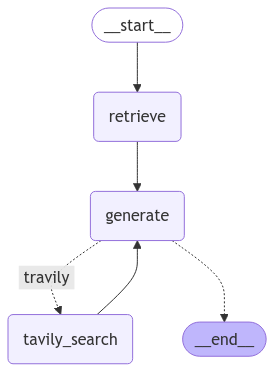

In [ ]:
# Tavily 검색 노드
def tavily_search(state: State):
    """Tavily 검색을 사용해 추가 문서를 검색합니다."""
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state["question"])

    # Tavily 검색 결과를 텍스트로 직렬화
    context = "\n\n".join(
        f"URL: {doc['url']}\nContent: {doc['content']}" for doc in search_docs
    )
    state['context'] = context
    return state

# RAG 검색 노드
def retrieve(state: State):
    # 검색기를 통해 질문에 관련된 문서 검색
    docs = retriever.get_relevant_documents(state["question"])
    # 검색된 문서를 하나의 텍스트로 연결
    context = "\n".join([doc.page_content for doc in docs])
    # return {"context": context}  # 텍스트로 연결된 문맥 반환
    state['context'] = context
    return state

# 생성노드
def generate(state: State):
    # Prompt에 질문과 문맥 전달
    messages = template.invoke({"question": state["question"], "context": state["context"]})
    # LLM 호출 및 응답 생성
    response = llm.invoke(messages)
    state["answer"] = response  # 생성된 답변 반환
    return state


# 상태 정의
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    loop_count : int

In [ ]:
# LangGraph 빌더 초기화
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node("retrieve", retrieve)  # 기본 검색 노드
graph_builder.add_node("generate", generate)  # 답변 생성 노드
graph_builder.add_node("tavily_search", tavily_search)  # Tavily 검색 노드


In [ ]:
def route_tools(
    state: State,
):
    # 루프 회수를 기록할 변수를 초기화 (state에 저장)
    if "loop_count" not in state:
        state["loop_count"] = 0

    # 루프 회수를 증가
    state["loop_count"] += 1

    # 루프 종료 조건: 특정 회수를 초과하면 END로 반환
    if state["loop_count"] > 3:  # 최대 루프 회수를 3으로 설정
        return END

    if state['answer'].content == '주어진 정보에서 질문에 대한 정보를 찾을 수 없습니다.':
        return "travily"
    else:
        return END

# 엣지 연결
graph_builder.add_edge(START, "retrieve")  # 시작 → 기본 검색
graph_builder.add_edge("retrieve", "generate")  # 기본 검색 → 답변 생성
# `tools_condition` 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고, 직접 응답이 가능한 경우 "END"를 반환
graph_builder.add_conditional_edges(
    source="generate",
    path=route_tools,
    # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
    path_map={"travily": "tavily_search", END: END},
)

graph_builder.add_edge("tavily_search", "generate")  # Tavily 검색 → 다시 답변 생성

# 그래프 컴파일
graph = graph_builder.compile()

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
result = graph.invoke({"question": "한은 총재의 이름은 무엇입니까?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

In [ ]:
result = graph.invoke({"question": "한국은행 부총재 이름은?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')